# Simulations of multi-agent auctions with various agent distributions

In [19]:
import pandas as pd
import numpy as np

with open('./data/validation_lin.csv') as csv_file3:
    df_val = pd.read_csv(csv_file3)
df_val = df_val[["click","bidprice","payprice","lin_bids", "non_lin_bids"]]

In [20]:

################
#### Utility functions to generate random intervals and bids from these intervals for rand agents
# Takes boolean  input : partition if we want intervals to be consecutive non overlapping rather than random.
################
def gen_rand_intervals(min,max,num_rands, partition):

    # If partition, generate consecutive non overlapping intervals between min and max bids
    if partition:
        nums = list(range(min, max + 1, int((max-min) / num_rands)))
        temp = [nums[i:i + 2] for i in range(len(nums) - 1)]
        temp.insert(0, [0, 0])
        intervals= np.array(temp)

    else:
        intervals = np.zeros((num_rands + 1, 2))

        # Generate n intervals upper bounded by max
        lower_bounds = np.random.randint(min ,max - 1 ,size = num_rands)

        # broadcast lower-bounds to create upper bounds
        upper_bounds = [np.random.randint(lower_bound + 1, max) for lower_bound in lower_bounds]

        intervals[1:num_rands+1,:]= list(zip(lower_bounds,upper_bounds))


    return intervals


def gen_rand_bids(intervals,num_rands,dataset):

    lower_bounds = intervals[:,0]
    upper_bounds = intervals[:,1]

    num_bids = dataset.shape[0]

    bids = np.zeros((num_rands + 1, num_bids))

    for i in range(1,num_rands+1):
        bids[i, :] = np.random.randint(lower_bounds[i], upper_bounds[i], size=num_bids)

     # Add winning bids from each auction
    bids[0, :] = dataset['payprice']

    return bids



In [21]:
################
#### Function to generate as many bids as there are auctions from intervals for ALL agents
################
def gen_all_bids(parameters,dataset = df_val):

    min_bid, max_bid, N_rand, N_lin, N_non_lin, noise,partition,inflation = parameters

    T = dataset.shape[0]
    N = N_rand + N_lin + N_non_lin
    # Include the +1 to reflect pay price in validation set (criterion 1)
    bids = np.zeros((N+1, T))
    lin_bids = dataset["lin_bids"]*inflation
    non_lin_bids = dataset["non_lin_bids"]*inflation

    # Generate Random intervals and from these random bids (include payprice in val-set)
    intervals = gen_rand_intervals(min_bid, max_bid, N_rand, partition)
    rand_bids = gen_rand_bids(intervals,N_rand,dataset)

    # Get linear bids from column in csv 'lin_bids'  then add noise

    # noisy_lin_bids = np.array([np.random.randint(lin_bids[k]- noise , lin_bids[k] + noise, T) for k in range(N_lin)])
    noisy_lin_bids = np.round([lin_bids + np.random.randint(-noise,noise,T) for _ in range(N_lin)])

    # Get non_linear bids from column in csv 'non_lin_bids'  then add noise
    noisy_non_lin_bids = np.round([non_lin_bids + np.random.randint(-noise,noise,T) for _ in range(N_non_lin)])

    # Concatenate all agents bids
    np.concatenate((rand_bids,noisy_lin_bids,noisy_non_lin_bids), axis=0, out=bids)

    return bids


In [22]:
################
#### Go through data ONCE, and evaluate the sampled bids from the intervals against auctions data (validation set)
################
def sample_eval(parameters, dataset = df_val):

    # num_agents = N_rand + N_lin + N_non_lin
    bids = gen_all_bids(parameters, dataset = df_val)
    num_agents = bids.shape[0] - 1 # ignore first row, current highest bidder in df_val
    max_agt_bids = np.amax(bids, axis=1)
    T = dataset.shape[0]

    # + 1 because we include an extra agent always bidding payprice (or slot price for test set)
    agent_wins = np.zeros(num_agents + 1)
    agent_budgets = np.ones(num_agents + 1) * budget
    agent_clicks = np.zeros(num_agents + 1)

    # Go through auctions one at a time and evaluate winner, update budget and ctr.
    # Can't do all at once as there is budget constraint to be checked each round.
    for t in range(T):
        agent_bids = bids[:,t]

        # Make sure agent have enough budget left to bid, if not their bid is 0. Compare budget to lowest bid agent want to make
        # if you choose min instead, risk of going negative
        agent_bids[agent_budgets < (agent_bids/1000)] = 0


        # Get highest bidder and payprice = max(second_highest bid, data payprice)
        highest_bidder = np.argmax(agent_bids)
        pay_price = np.sort(agent_bids)[-2]

        agent_wins[highest_bidder] += 1
        agent_clicks[highest_bidder] += df_val['click'].iloc[t]

        # if t%300 == 0 and t>0:
        #     print('#######NEXT ROUND########### ')
        #     print(agent_bids)
        #     print(agent_budgets)
        #     print(highest_bidder)
        #     print(pay_price)

        if highest_bidder != 0:
            agent_budgets[highest_bidder] -= pay_price/1000


    return agent_clicks,agent_wins, agent_budgets


################
#### Go through data ITER times, store performance and return average performances across iterations, return best agent.
################
def get_best_agent(parameters, dataset, iter = 10):

    N_rand, N_lin, N_non_lin = parameters[2:5]
    num_agents = N_rand + N_lin + N_non_lin
    total_clicks = np.zeros(num_agents + 1)
    total_wins = np.zeros(num_agents + 1)
    total_budgets = np.zeros(num_agents + 1)

    for _ in range(iter):
        agent_clicks, agent_wins, agent_budgets = sample_eval(parameters, dataset)
        total_clicks += agent_clicks
        total_wins += agent_wins
        total_budgets += agent_budgets

    avg_clicks = np.array(total_clicks)/iter
    avg_wins = np.array(total_wins)/iter
    avg_rem_budget = np.array(total_budgets)/iter

    ######### Print Results for each agent ###############
    # for i in range(num_agents +1 ):
    #     print(" Agent: {} \t  Managed to get: {} clicks. Won {} auctions. Left with budget: {}"
    #           .format(i, int(avg_clicks[i]),int(avg_wins[i]),int(avg_rem_budget[i])))

    avg_rand = sum(avg_clicks[1:N_rand+1])
    avg_lin = sum(avg_clicks[N_rand+1:N_rand + N_lin + 1])
    avg_nonlin = sum(avg_clicks[N_rand+N_lin:num_agents + 1])

    clicks_per_agt_type = [parameters[:2],avg_rand/N_rand,avg_lin/N_lin,avg_nonlin/N_non_lin]

    # print("\n Random Interval: {} \n Expected clicks per Random agent: {} \n Expected clicks per Linear agent: {} \n"
    #       " Expected clicks per Non-linear agent:{}".format(*clicks_per_agt_type))
    ##########################################


    winning_agent = np.argmax(avg_clicks[1:]) + 1       # ignore first element: stores "pay price" from current dataset
    win_num_clicks = avg_clicks[winning_agent]
    # winning_interval = intervals[winning_agent,:]
    winning_count = avg_wins[winning_agent]
    winner_rem_budget = avg_rem_budget[winning_agent]

    best_agent_stats = [winning_agent,win_num_clicks, winning_count, round(winner_rem_budget,2)]

    return clicks_per_agt_type, best_agent_stats

############ END OF CODE ###############################################################################################


In [23]:
######## PARAMETERS YOU CAN CHANGE ####
# min_rand_bid = 25000   # lower bound of intervals random bidders use to generate bids
# max_rand_bid = 26000  # upper bound of intervals random bidders use to generate bids

np.random.seed(0)
N_rand = 2    # Number of Random interval bidders in simulation
N_lin = 25    # Number of Linear bidder in simulation
N_non_lin = 2  # Number of non linear bidder in simulations

budget = 6250*(1)   # Applies to each agent in simulation. Keep total budget for all agents constant to have good comparisons

noise = 5           # integer to introduce noise to linear and non linear bids Number of times

iterations = 1   # Number of times script generates new bids (for each agents) and evaluates..

inflation = 1 # amount by which we want to inflate linear and non-linear bids in order to account for criterion 2 dynamics

# Parameter to decide on shape of random intervals for random bidding agents. of true-> consecutive non overlapping
# intervals are used (linspace like)
partition = False

# List of parameters:
# params = [min_rand_bid, max_rand_bid, N_rand, N_lin, N_non_lin, noise,partition,inflation]
########################################################################################################


## Run simulations by changing number of each agent type 

In [25]:
######### EXECUTE BELOW CODE TO GET PERFORMANCE OF AGENTS AND BEST AGENT GIVEN PARAMETERS ##############

# Results of simulation on validation set ( IMPORTANT! : AGENT 0 is a dummy to represent payprice of validation dataset
# or slot price of test set)

# print("\n Best Agent: {}. Managed to get {} clicks. Won {} auctions. Budget left with: {}".format(*get_best_agent(params, df_val, 1)[1]))



def simulate(splits):
    
    for distrib in splits:

        N_rand, N_lin, N_non_lin = distrib

        avg_clicks_per_rand_lvl =[]

        for i in range(10):
            min_rand_bid = 250*i
            max_rand_bid = 250*(i+1)

            params  = [min_rand_bid, max_rand_bid, N_rand, N_lin, N_non_lin, noise,partition,inflation]

            avg_clicks_per_rand_lvl.append(get_best_agent(params, df_val, 1)[0][1:])

    #     print(np.round(avg_clicks_per_rand_lvl))

        avg_clicks_across_rand_lvls = np.mean(np.array(avg_clicks_per_rand_lvl), axis =0)

        print("Average clicks per agent across random bids intervals for {} split for Rand/Lin/Non-lin respectively: \n {} ".format(distrib,avg_clicks_across_rand_lvls))

simulate([[25,2,2],[2,25,2],[2,2,25]])

Average clicks per agent across random bids intervals for [25, 2, 2] split for Rand/Lin/Non-lin respectively: 
 [ 3.624 27.9   28.65 ] 
Average clicks per agent across random bids intervals for [2, 25, 2] split for Rand/Lin/Non-lin respectively: 
 [10.5    5.928  1.05 ] 
Average clicks per agent across random bids intervals for [2, 2, 25] split for Rand/Lin/Non-lin respectively: 
 [10.8  25.15  3.9 ] 


In [26]:
simulate([[15,7,7],[7,15,7],[7,7,15]])

Average clicks per agent across random bids intervals for [15, 7, 7] split for Rand/Lin/Non-lin respectively: 
 [ 4.26       16.6         1.81428571] 
Average clicks per agent across random bids intervals for [7, 15, 7] split for Rand/Lin/Non-lin respectively: 
 [6.08571429 8.77333333 0.52857143] 
Average clicks per agent across random bids intervals for [7, 7, 15] split for Rand/Lin/Non-lin respectively: 
 [ 5.58571429 19.18571429  0.91333333] 


In [27]:
simulate([[10,9,9],[9,10,9],[9,9,10]])

Average clicks per agent across random bids intervals for [10, 9, 9] split for Rand/Lin/Non-lin respectively: 
 [ 4.87       14.14444444  1.06666667] 
Average clicks per agent across random bids intervals for [9, 10, 9] split for Rand/Lin/Non-lin respectively: 
 [ 5.2  12.86  0.8 ] 
Average clicks per agent across random bids intervals for [9, 9, 10] split for Rand/Lin/Non-lin respectively: 
 [ 5.17777778 14.34444444  0.76      ] 


# How about if we inflate all linear and non linear bid prices by a factor of 5? (Tim's point...)

In [28]:
inflation = 5
simulate([[25,2,2],[2,25,2],[2,2,25]])

Average clicks per agent across random bids intervals for [25, 2, 2] split for Rand/Lin/Non-lin respectively: 
 [ 3.088  7.85  22.1  ] 
Average clicks per agent across random bids intervals for [2, 25, 2] split for Rand/Lin/Non-lin respectively: 
 [ 3.8   4.9  19.65] 
Average clicks per agent across random bids intervals for [2, 2, 25] split for Rand/Lin/Non-lin respectively: 
 [2.7   5.55  7.384] 


In [29]:
inflation = 5
simulate([[15,7,7],[7,15,7],[7,7,15]])
simulate([[10,9,9],[9,10,9],[9,9,10]])

Average clicks per agent across random bids intervals for [15, 7, 7] split for Rand/Lin/Non-lin respectively: 
 [ 2.73333333  5.44285714 13.77142857] 
Average clicks per agent across random bids intervals for [7, 15, 7] split for Rand/Lin/Non-lin respectively: 
 [ 2.54285714  4.94       13.51428571] 
Average clicks per agent across random bids intervals for [7, 7, 15] split for Rand/Lin/Non-lin respectively: 
 [2.11428571 5.7        9.83333333] 
Average clicks per agent across random bids intervals for [10, 9, 9] split for Rand/Lin/Non-lin respectively: 
 [ 2.55        5.27777778 12.91111111] 
Average clicks per agent across random bids intervals for [9, 10, 9] split for Rand/Lin/Non-lin respectively: 
 [ 2.43333333  5.15       13.        ] 
Average clicks per agent across random bids intervals for [9, 9, 10] split for Rand/Lin/Non-lin respectively: 
 [ 2.45555556  5.33333333 12.75      ] 


### Temporal clustering of clicks:

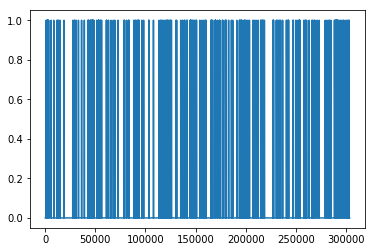

In [33]:
import matplotlib.pyplot as plt
plt.plot(range(df_val.shape[0]),df_val['click'])